In [1]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import *
from configs import DatasetConfiguration
from utils_train import *
from configs import *
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import os
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
import seaborn as sb
import deepdish as dd

seed = 42
np.random.seed(seed=seed)

splitting = 'custom'
data_setting = 'rawflt'
model_setting = 'conv1d'

clean = True

### data collecting

In [2]:
mebios = DatasetConfiguration(names=['Suzukii_RL'])
mebios.select_all(); 
mebios.read();
if clean:
    mebios.clean();
mebios.df.labels.value_counts()

Dataset - Suzukii_RL - exists: True


L    16501
R    11457
Name: labels, dtype: int64

Dataset - Rodrigo - exists: True
['20200309', '20200305', '20200302', '20200311', '20200310', '20200228', '20200307', '20200304', '20200301', '20200303', '20200308', '20200229', '20200316', '20200315', '20200306', '20200227', '20200314', '20200313', '20200312']
3912 train filenames, 994 test filenames


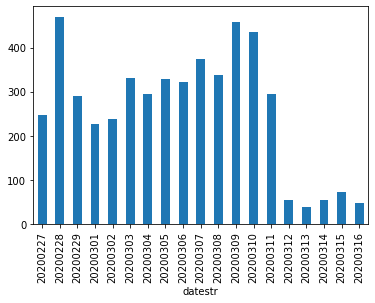

In [3]:
rodr_tr,rodr_ts = train_test_filenames2(dataset='Rodrigo',species='D. melanogaster', clean=clean, plot=True, test_dates=['20200310','20200311','20200312', '20200313', '20200314', '20200315','20200316'])

In [4]:
rodsuz = DatasetConfiguration(names=['Rodrigo'])
rodsuz.select(name='Rodrigo', species=['D. suzukii'])
rodsuz.read()
if clean:
    rodsuz.clean()
rodsuz.df.labels.value_counts()    

Dataset - Rodrigo - exists: True


D. suzukii    866
Name: labels, dtype: int64

In [5]:
mebiosmel = DatasetConfiguration(names=['Melanogaster_RL'])
mebiosmel.select(name='Melanogaster_RL', species=['W'])
mebiosmel.read()
if clean:
    mebiosmel.clean()
mebiosmel.df.labels = mebiosmel.df.labels.apply(lambda x: x.replace("W", "D. melanogaster"))
mebiosmel.df.labels.value_counts()

Dataset - Melanogaster_RL - exists: True


D. melanogaster    524
Name: labels, dtype: int64

Dataset - LG - exists: True
['20180925', '20180922', '20180923', '20180920', '20180921', '20180919', '20180924', '20180926']
5379 train filenames, 1745 test filenames


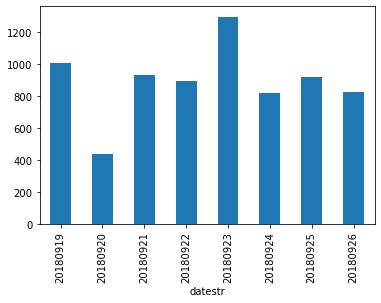

In [6]:
lg_tr, lg_ts = train_test_filenames2(dataset='LG',species='LG_zapr_26_09', clean=clean, plot=True, test_dates=['20180926', '20180925'])
lg_tr.labels = lg_tr.labels.apply(lambda x: f'{x.replace("LG_zapr_26_09", "Zaprionus")}')
lg_ts.labels = lg_ts.labels.apply(lambda x: f'{x.replace("LG_zapr_26_09", "Zaprionus")}')

## train

In [7]:
train_meb = mebios.df[mebios.df.labels.isin(['L'])]
train = pd.concat([train_meb, rodr_tr, lg_tr])
train.labels = train.labels.apply(lambda x: f'{x.replace("L", "D. suzukii")}')
train.labels.value_counts()

D. suzukii         16501
Zaprionus           5379
D. melanogaster     3912
Name: labels, dtype: int64

## test

In [8]:
test_meb = mebios.df[mebios.df.labels.isin(['R'])]
test_meb.labels = test_meb.labels.apply(lambda x: x.replace("R", "D. suzukii"))
test = pd.concat([test_meb, rodr_ts, rodsuz.df,lg_ts, mebiosmel.df])
test.labels.value_counts()

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


D. suzukii         12323
Zaprionus           1745
D. melanogaster     1518
Name: labels, dtype: int64

In [9]:
pd.concat([train, test]).duplicated().sum()

0

### data splitting

In [10]:
if splitting == 'random':
    tmp = pd.concat([train, test])
    X_train, X_test, y_train, y_test = train_test_split(tmp.fnames.tolist(), tmp.labels.tolist(), shuffle=True, random_state=42)
elif splitting == 'custom':
    X_train = train.fnames.tolist()
    X_test = test.fnames.tolist()
    y_train = train.labels.tolist()
    y_test = test.labels.tolist()
else:
    raise ValueError('Wrong splitting method')
    
print(f"train: \n{pd.Series(y_train).value_counts()}\n")
print(f"test: \n{pd.Series(y_test).value_counts()}")

train: 
D. suzukii         16501
Zaprionus           5379
D. melanogaster     3912
dtype: int64

test: 
D. suzukii         12323
Zaprionus           1745
D. melanogaster     1518
dtype: int64


In [11]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
pd.Series(y_test).value_counts()

1    12323
2     1745
0     1518
dtype: int64

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, shuffle=True)

# Saving

In [13]:
pd.DataFrame(zip(X_train, y_train), columns=['x','y']).to_csv(f"{TEMP_DATADIR}/df_train_{data_setting}_{model_setting}_{splitting}.csv", index=False)

In [14]:
pd.DataFrame(zip(X_val, y_val), columns=['x','y']).to_csv(f"{TEMP_DATADIR}/df_val_{data_setting}_{model_setting}_{splitting}.csv", index=False)

In [15]:
pd.DataFrame(zip(X_test, y_test), columns=['x','y']).to_csv(f"{TEMP_DATADIR}/df_test_{data_setting}_{model_setting}_{splitting}.csv", index=False)